In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers.schedules import ExponentialDecay
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import tensorflow as tf



In [2]:
#PreProcessing
EPOCHS = 10
BS = 32
initial_learning_rate = 1e-4


DIRECTORY = r"inter the location of the data set"
CATEGORIES = ["with_mask", "without_maks"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image) #because we use  mobilenet

        data.append(image)
        labels.append(category)
        

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
#deep learning models only work with arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
        
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                   test_size=0.20, stratify=labels, random_state=42)

[INFO] loading images...


In [3]:
img_shape = trainX[0].shape

model=Sequential()

model.add(layers.Conv2D(32,(3,3),input_shape=img_shape))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories


adam = tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(x=trainX,
                    y=trainY,
                    batch_size=100,
                    epochs=20,
                    validation_split=0.2,
                    verbose=2,
                    shuffle=True)
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

Epoch 1/20
3/3 - 15s - loss: 1.1201 - accuracy: 0.5117 - val_loss: 0.7022 - val_accuracy: 0.5156 - 15s/epoch - 5s/step
Epoch 2/20
3/3 - 12s - loss: 0.7030 - accuracy: 0.5234 - val_loss: 0.6693 - val_accuracy: 0.5156 - 12s/epoch - 4s/step
Epoch 3/20
3/3 - 11s - loss: 0.6532 - accuracy: 0.7539 - val_loss: 0.5732 - val_accuracy: 0.8438 - 11s/epoch - 4s/step
Epoch 4/20
3/3 - 11s - loss: 0.5223 - accuracy: 0.8320 - val_loss: 0.2705 - val_accuracy: 0.9531 - 11s/epoch - 4s/step
Epoch 5/20
3/3 - 11s - loss: 0.2384 - accuracy: 0.9336 - val_loss: 0.1187 - val_accuracy: 0.9375 - 11s/epoch - 4s/step
Epoch 6/20
3/3 - 11s - loss: 0.1303 - accuracy: 0.9531 - val_loss: 0.0696 - val_accuracy: 0.9688 - 11s/epoch - 4s/step
Epoch 7/20
3/3 - 11s - loss: 0.0700 - accuracy: 0.9766 - val_loss: 0.0162 - val_accuracy: 1.0000 - 11s/epoch - 4s/step
Epoch 8/20
3/3 - 11s - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.0385 - val_accuracy: 0.9844 - 11s/epoch - 4s/step
Epoch 9/20
3/3 - 11s - loss: 0.0280 - accuracy: 

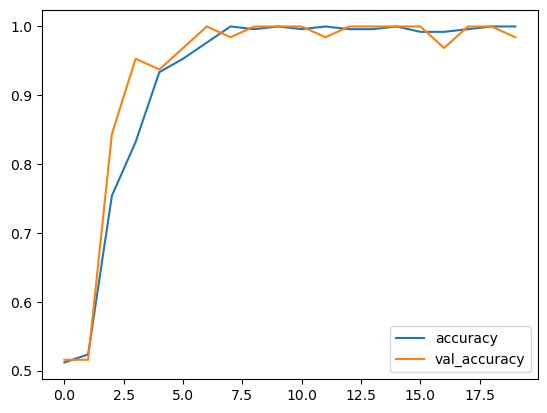

In [4]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy']);

In [5]:

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)
input_tensor = Input(shape=(224, 224, 3))
baseModel = MobileNetV2(weights="imagenet", include_top=False ,input_tensor = input_tensor)

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel) 


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96)


opt = Adam(learning_rate=lr_schedule)

model.compile(loss="binary_crossentropy", optimizer=opt,
               metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),  
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] compiling model...
[INFO] training head...
Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 0.7678 - accuracy: 0.5844 - val_loss: 0.5395 - val_accuracy: 0.8750
Epoch 2/10
10/10 [==============================] - 10s 975ms/step - loss: 0.5908 - accuracy: 0.7156 - val_loss: 0.3710 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.4450 - accuracy: 0.8656 - val_loss: 0.2630 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.3809 - accuracy: 0.8781 - val_loss: 0.2025 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.2921 - accuracy: 0.9312 - val_loss: 0.1607 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 10s 950ms/step - loss: 0.2545 - accuracy: 0.9312 - val_loss: 0.1214 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 0.1986 - accuracy: 0.9750 - val_

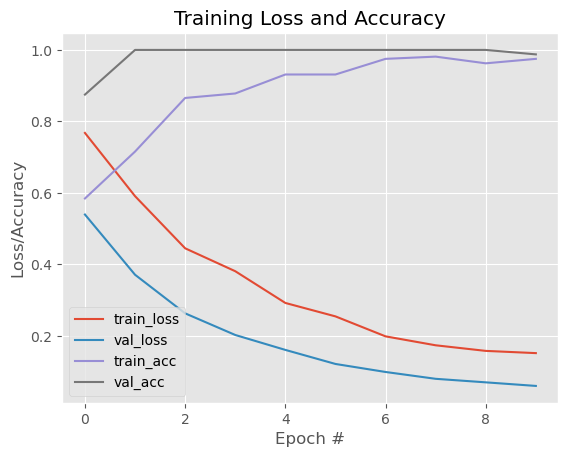

In [6]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
